In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Download Pascal VOC Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O VOCtrainval.tar

--2022-07-10 03:58:10--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval.tar’

VOCtrainval.tar     100%[===================>]   1.86G  14.1MB/s    in 2m 17s  

2022-07-10 04:00:28 (13.9 MB/s) - ‘VOCtrainval.tar’ saved [1999639040/1999639040]



### Extracting Images along with Masks

In [1]:
!tar -xvf VOCtrainval.tar

tar: VOCtrainval.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


## Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from PIL import Image
import matplotlib.image as mpimg
import sys
import shutil
import os

### Reading Images

In [ ]:
img_w, img_h = 512, 512
batch_size = 4
num_classes = 21
def read_img(image_path,mask=False):
    img = tf.io.read_file(image_path)
    if mask:
      img = tf.image.decode_png(img, channels=1)
      img.set_shape([None, None, 1])
      img = (tf.image.resize(images=img, size=[
                    img_h, img_w]))  
      img = tf.cast(img,tf.float32)
      print(img.get_shape)
    else:
      img = tf.image.decode_png(img, channels=3)
      img.set_shape([None, None, 3])
      img = (tf.image.resize(images=img, size=[
                    img_h, img_w]))
      img = tf.cast(img,tf.float32) / 127.5 - 1
    return img

def load_data(img_list,mask_list):
  img = read_img(img_list)
  mask = read_img(mask_list,mask=True)
  return img, mask

## Preprocessing and Spliting into train/val

In [ ]:
def data_generator(img_list,mask_list):
  dataset = tf.data.Dataset.from_tensor_slices((img_list,
                                                    mask_list))
  dataset = dataset.map(load_data,num_parallel_calls=
                        tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size,drop_remainder=True)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset
path = '/content/VOCdevkit/VOC2012/trainImages'
maskList = sorted(glob('VOCdevkit/VOC2012/SegmentationClass/*'))
dst = '/content/VOCdevkit/VOC2012/trainImages/'
isExist = os.path.exists(path)

if not isExist:
  # Create a new directory because it does not exist 
  print("making new directory")
  os.mkdir(path)

for image in maskList:
  src = "VOCdevkit/VOC2012/JPEGImages/" + image[36:-3] + "jpg"
  print("processing = ", image)
  img = np.array(Image.open(image))


  img= np.where(img == 255, 0, img)
  
  img = Image.fromarray(img)
  img.save(image)
  shutil.copy(src,dst)
print("PreProcessing done")
train_images_folder = sorted(glob('VOCdevkit/VOC2012/trainImages/*'))[:2800]
train_mask_folder = sorted(glob('VOCdevkit/VOC2012/SegmentationClass/*'))[:2800]
valid_images_folder = sorted(glob('VOCdevkit/VOC2012/trainImages/*'))[2801:2913]
valid_mask_folder = sorted(glob('VOCdevkit/VOC2012/SegmentationClass/*'))[2801:2913]

train_dataset = data_generator(train_images_folder,train_mask_folder)
valid_dataset = data_generator(valid_images_folder,valid_mask_folder)

Streaming output truncated to the last 5000 lines.
processing =  VOCdevkit/VOC2012/SegmentationClass/2008_008324.png
Before value =  [  0  14 255] count =  [161221  22663   3616]
value =  [ 0 14] count =  [164837  22663]
processing =  VOCdevkit/VOC2012/SegmentationClass/2008_008335.png
Before value =  [  0  11  15 255] count =  [69210 28396 76162 14732]
value =  [ 0 11 15] count =  [83942 28396 76162]
processing =  VOCdevkit/VOC2012/SegmentationClass/2008_008343.png
Before value =  [  0   6   7  15 255] count =  [156837  16009   2915   1765   9974]
value =  [ 0  6  7 15] count =  [166811  16009   2915   1765]
processing =  VOCdevkit/VOC2012/SegmentationClass/2008_008362.png
Before value =  [  0   5   9  11  15 255] count =  [79280   587  1349 28838 55729 21717]
value =  [ 0  5  9 11 15] count =  [100997    587   1349  28838  55729]
processing =  VOCdevkit/VOC2012/SegmentationClass/2008_008392.png
Before value =  [  0  13 255] count =  [158974  22910   5616]
value =  [ 0 13] count =  [1

## Dataset Visualization

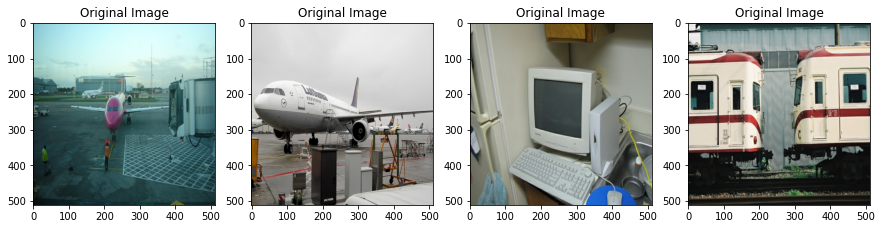

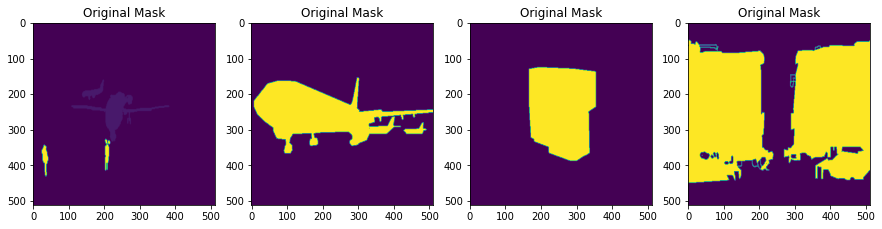

In [ ]:
dataset = train_dataset
plt.figure(figsize=(15,15))
for i in range(batch_size):
  for val in dataset.take(1):
    img = tf.cast((val[0][i]+1)*127.5,tf.uint8)
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title("Original Image")
plt.show()

plt.figure(figsize=(15,15))
for i in range(batch_size):
  for val in dataset.take(1):
    plt.subplot(1,4,i+1)
    plt.imshow(tf.squeeze(val[1][i]))
    plt.title("Original Mask")
plt.show()

## Defining DeepLab V3 Plus Model

In [ ]:
def AtrousSpatialPyramidPooling(model_input):
  dims = tf.keras.backend.int_shape(model_input)

  layer = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],
                                                      dims[-2]))(model_input)
  layer = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same',
                                 kernel_initializer = 'he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  out_pool = tf.keras.layers.UpSampling2D(size = (dims[-3] // layer.shape[1],
                                               dims[-2] // layer.shape[2]),
                                        interpolation = 'bilinear')(layer)
  
  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_1 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 6, padding = 'same', 
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_6 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 12, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_12 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 18, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_18 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Concatenate(axis = -1)([out_pool, out_1,
                                                    out_6, out_12,
                                                    out_18])

  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  model_output = tf.keras.layers.ReLU()(layer)
  return model_output


In [ ]:
def DeeplabV3Plus(num_classes = 21):
  model_input = tf.keras.Input(shape=(img_h,img_w,3))
  resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet',
                                            include_top = False,
                                            input_tensor = model_input)
  layer = resnet50.get_layer('conv4_block6_2_relu').output
  layer = AtrousSpatialPyramidPooling(layer)
  input_a = tf.keras.layers.UpSampling2D(size = (img_h // 4 // layer.shape[1],
                                                 img_w // 4 // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)

  input_b = resnet50.get_layer('conv2_block3_2_relu').output
  input_b = tf.keras.layers.Conv2D(48, kernel_size = (1,1), padding = 'same',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(input_b)
  input_b = tf.keras.layers.BatchNormalization()(input_b)
  input_b = tf.keras.layers.ReLU()(input_b)

  layer = tf.keras.layers.Concatenate(axis = -1)([input_a, input_b])

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.Conv2D(256, kernel_size =3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.UpSampling2D(size = (img_h // layer.shape[1],
                                                 img_w // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)
  model_output = tf.keras.layers.Conv2D(num_classes, kernel_size = (1,1),
                                   padding = 'same')(layer)
  return tf.keras.Model(inputs = model_input, outputs = model_output)

model = DeeplabV3Plus()
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## Training Model

In [ ]:
epochs=500
step_per_epoch=len(train_images_folder)//batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,metrics=['accuracy'])
filepath = '/content/drive/MyDrive/deeplab_V3_model.h5'
# filepath = '/content/deeplab_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='loss',
                                                save_weights_only=True,
                                                mode='min')

model.fit(train_dataset,steps_per_epoch=step_per_epoch, epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size,callbacks=[checkpoint])

Epoch 1/5
700/700 [==============================] - 288s 379ms/step - loss: 1.1716 - accuracy: 0.7387 - val_loss: 1.4631 - val_accuracy: 0.7082
Epoch 2/5
700/700 [==============================] - 267s 381ms/step - loss: 1.0426 - accuracy: 0.7464 - val_loss: 1.7839 - val_accuracy: 0.6149
Epoch 3/5
700/700 [==============================] - 269s 384ms/step - loss: 0.9835 - accuracy: 0.7520 - val_loss: 1.1111 - val_accuracy: 0.7074
Epoch 4/5
700/700 [==============================] - 267s 381ms/step - loss: 0.9252 - accuracy: 0.7591 - val_loss: 1.1096 - val_accuracy: 0.7130
Epoch 5/5
700/700 [==============================] - 269s 384ms/step - loss: 0.8787 - accuracy: 0.7666 - val_loss: 0.9907 - val_accuracy: 0.7366


## Inference

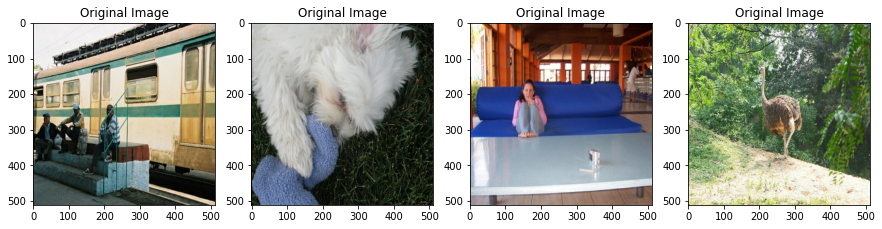

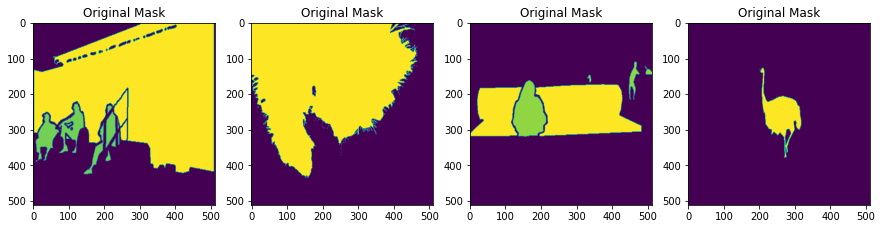

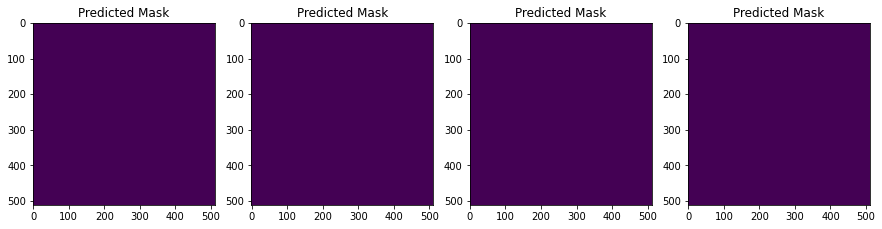

In [ ]:
model.load_weights('/content/drive/MyDrive/deeplab_V3_model.h5')

def inference(dataset):
 plt.figure(figsize=(25,15))
 for i in range(2,4):
    for val in dataset.take(10):
      img = tf.cast((val[0][i]+1)*127.5,tf.uint8)
      plt.subplot(1,4,i+1)
      plt.imshow(img)
      plt.title("Original Image")
 plt.show()
 
 plt.figure(figsize=(25,15))
 for i in range(2,4):
    for val in dataset.take(1):
      plt.subplot(1,4,i+1)
      plt.imshow(tf.squeeze(val[1][i]))
      plt.title("Original Mask")
 plt.show()
 
 plt.figure(figsize=(25,15))
 for i in range(2,4):
    for val in dataset.take(1):
      img = val[0][i]
      plt.subplot(1,4,i+1)
      predsTrain = model.predict(np.expand_dims((img),axis=0))
      out=np.squeeze(predsTrain)
      y = np.argmax(out, axis=2)
      plt.imshow(y)
      plt.title("Predicted Mask")

 plt.show()

 plt.figure(figsize=(25,15))
 for i in range(2,4):
    for val in dataset.take(1):
      img = val[0][i]
      plt.subplot(1,4,i+1)
      mask = np.argmax(model.predict(img[None, ...])[0], axis=-1)
      img = img.numpy()
      img[mask == 0] = 255
      plt.imshow(img)
      plt.title("Segmented Image")

 plt.show()

inference(valid_dataset)